Revenue Prediction
==================
In this project the goal is to predict movies revenue using their features. revenue is given by ( box_office - budget ) so the main goal is to predict box office. 

1. Prepare and preprocess the given data. 

2. After exploring data find, select and especially create new features. ignore others.

3. Prepare features to feed the model. 

4. Select and try different models.

5. Document and report each step using relative plots and a brief explanation. finally report the best suited model and justify why did it performed well.



- Keep in mind that in this task accuracy itself only has only part of score.

- Hint: to create new features you can use credit attributes. Think of it this way, what affects box office?  

**Tools** 

importing useful tools and libraries. you may use any other library as well.

In [1]:
# ============================================
# IMPORTING LIBRARIES
# ============================================
import warnings
warnings.filterwarnings('ignore')

import ast
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Modelling
from scipy.stats import randint
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.tree import export_graphviz
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Tree Visualisation
import graphviz
from xgboost import XGBRegressor
from IPython.display import Image

In [2]:
np.random.seed(101)

In [3]:
# Your project struct must look like this,

# |── Name_SID.zip
# │   ├── data
# │   │       ├── rotten_tomatoes_5000_movies.csv
# │   │       ├── rotten_tomatoes_5000_movies.csv
# │   ├── *.ipynb
# │   ├── document.pdf

df_movies = pd.read_csv(r"data/rotten_tomatoes_5000_movies.csv")
df_credit = pd.read_csv(r"data/rotten_tomatoes_5000_credits.csv")

In [4]:
print("Movies Dataset Info:")
print(df_movies.info())
print("\nMovies Dataset Preview:")
print(df_movies.head())

print("\nCredits Dataset Info:")
print(df_credit.info())
print("\nCredits Dataset Preview:")
print(df_credit.head())

print("\nMissing Values in Movies Dataset:")
print(df_movies.isnull().sum())

print("\nMissing Values in Credits Dataset:")
print(df_credit.isnull().sum())

Movies Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   rt_production_budget     4803 non-null   int64  
 1   rt_genres                4803 non-null   object 
 2   rt_website               1712 non-null   object 
 3   rt_movie_id              4803 non-null   int64  
 4   rt_keywords              4803 non-null   object 
 5   rt_original_language     4803 non-null   object 
 6   rt_original_title        4803 non-null   object 
 7   rt_synopsis              4800 non-null   object 
 8   rt_audience_score        4803 non-null   float64
 9   rt_studios               4803 non-null   object 
 10  rt_production_countries  4803 non-null   object 
 11  rt_release_date          4802 non-null   object 
 12  rt_box_office            4803 non-null   int64  
 13  rt_runtime               4801 non-null   float64
 14  rt_

In [5]:
# Step 1: Handle Missing and Inconsistent Data
df_movies['rt_release_date'] = pd.to_datetime(df_movies['rt_release_date'], errors='coerce')
df_movies = df_movies.dropna(subset=['rt_release_date'])
df_movies['rt_tagline'] = df_movies['rt_tagline'].fillna('No tagline')

# Step 2: Parse JSON-like Strings into Lists
def parse_json_field(field_str, field_name):
    try:
        items = ast.literal_eval(field_str)
        return [item['name'] for item in items if isinstance(item, dict)]
    except (ValueError, SyntaxError, TypeError):
        return []

# Apply the parsing function to relevant fields
df_movies['parsed_genres'] = df_movies['rt_genres'].apply(lambda x: parse_json_field(x, 'genres'))
df_movies['parsed_keywords'] = df_movies['rt_keywords'].apply(lambda x: parse_json_field(x, 'keywords'))
df_movies['parsed_studios'] = df_movies['rt_studios'].apply(lambda x: parse_json_field(x, 'studios'))
df_movies['parsed_countries'] = df_movies['rt_production_countries'].apply(lambda x: parse_json_field(x, 'countries'))
df_movies['parsed_languages'] = df_movies['rt_languages'].apply(lambda x: parse_json_field(x, 'languages'))

# Step 3: Extract Temporal Features (Year, Month, Day)
df_movies['release_year'] = df_movies['rt_release_date'].dt.year
df_movies['release_month'] = df_movies['rt_release_date'].dt.month
df_movies['release_day'] = df_movies['rt_release_date'].dt.day

# Step 4: Calculate Revenue-to-Budget Ratio
df_movies['revenue_to_budget_ratio'] = df_movies['rt_box_office'] / (df_movies['rt_production_budget'] + 1e-6)

# Step 5: Categorize Runtime
def categorize_runtime(runtime):
    if runtime < 90:
        return 'Short'
    elif runtime <= 120:
        return 'Medium'
    else:
        return 'Long'

df_movies['runtime_category'] = df_movies['rt_runtime'].apply(categorize_runtime)

# Step 6: Feature Engineering (Combine Genres, Countries, Languages)
df_movies['combined_features'] = df_movies.apply(
    lambda row: {
        'genres': row['parsed_genres'],
        'countries': row['parsed_countries'],
        'languages': row['parsed_languages']
    },
    axis=1
)

# Step 7: Dimensionality Reduction Using PCA (Optional for Numeric Features)
numeric_columns = ['rt_production_budget', 'rt_box_office', 'rt_critics_score', 'rt_review_count']
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(df_movies[numeric_columns])
pca_columns = [f'PCA_{i+1}' for i in range(reduced_data.shape[1])]
df_movies[pca_columns] = reduced_data

# Step 8: Save Cleaned Dataset
df_movies_cleaned = df_movies.drop(columns=['rt_genres', 'rt_keywords', 'rt_studios', 'rt_production_countries', 'rt_languages'])
df_movies_cleaned.to_csv("cleaned_movies_dataset.csv", index=False)

# Display the first few rows of the cleaned dataset
print("Cleaned Movies Dataset:")
print(df_movies_cleaned.head())

# Step 9: Parse and Extract Actor/Staff Information from 'rt_actors' and 'rt_staff'
def parse_actors(actors_str):
    try:
        actors = ast.literal_eval(actors_str)
        return [
            {"name": actor.get("name", ""), "gender": actor.get("gender", None), "character": actor.get("character", "")}
            for actor in actors
        ]
    except (ValueError, SyntaxError):
        return []

def parse_staff(staff_str):
    try:
        staff = ast.literal_eval(staff_str)
        return [
            {"name": member.get("name", ""), "gender": member.get("gender", None), "job": member.get("job", "")}
            for member in staff
        ]
    except (ValueError, SyntaxError):
        return []

# Apply parsing functions
df_credit['parsed_actors'] = df_credit['rt_actors'].apply(parse_actors)
df_credit['parsed_staff'] = df_credit['rt_staff'].apply(parse_staff)

# Feature Engineering: Count Actors, Staff, and Gender Breakdown
df_credit['num_actors'] = df_credit['parsed_actors'].apply(len)
df_credit['num_staff'] = df_credit['parsed_staff'].apply(len)

# Extract gender counts for actors
def extract_gender_counts(actors):
    male_count = sum(1 for actor in actors if actor.get("gender") == 2)
    female_count = sum(1 for actor in actors if actor.get("gender") == 1)
    return {"male": male_count, "female": female_count}

df_credit['actor_gender_counts'] = df_credit['parsed_actors'].apply(extract_gender_counts)
df_credit['male_actors'] = df_credit['actor_gender_counts'].apply(lambda x: x['male'])
df_credit['female_actors'] = df_credit['actor_gender_counts'].apply(lambda x: x['female'])

# One-Hot Encoding for Movie Titles
encoder = OneHotEncoder(sparse_output=False)
encoded_titles = encoder.fit_transform(df_credit[['rt_title']])
encoded_titles_df = pd.DataFrame(encoded_titles, columns=encoder.categories_[0], index=df_credit.index)
df_credit = pd.concat([df_credit, encoded_titles_df], axis=1)

# Clean Data: Drop Original Columns
df_credit_cleaned = df_credit.drop(columns=['rt_actors', 'rt_staff', 'actor_gender_counts'])
df_credit_cleaned.to_csv("cleaned_credits_dataset.csv", index=False)

# Step 10: Merge Movie Data with Credit Data
df_credit_cleaned = df_credit_cleaned.merge(
    df_movies[['rt_movie_id', 'rt_production_budget', 'rt_box_office', 'parsed_genres', 'parsed_countries', 'parsed_languages', 'rt_critics_score', 'rt_review_count']],
    on='rt_movie_id', how='left'
)

# Step 11: Calculate Genre Costs Including Reviews and Critics Scores
def calculate_genre_costs_with_reviews(row):
    genres = row['parsed_genres']
    # Ensure genres is a list before proceeding
    if not isinstance(genres, list):
        return {}
    
    budget, box_office, reviews, critics_score = row['rt_production_budget'], row['rt_box_office'], row['rt_review_count'], row['rt_critics_score']
    genre_costs = {}
    for genre in genres:
        if genre not in genre_costs:
            genre_costs[genre] = {'total_budget': 0, 'total_revenue': 0, 'total_reviews': 0, 'critics_score': 0, 'count': 0}
        genre_costs[genre]['total_budget'] += budget
        genre_costs[genre]['total_revenue'] += box_office
        genre_costs[genre]['total_reviews'] += reviews
        genre_costs[genre]['critics_score'] += critics_score
        genre_costs[genre]['count'] += 1
    return genre_costs

df_credit_cleaned['genre_costs'] = df_credit_cleaned.apply(calculate_genre_costs_with_reviews, axis=1)

# Normalize Critics Score by Genre Count
for _, row in df_credit_cleaned.iterrows():
    for genre, stats in row['genre_costs'].items():
        stats['critics_score'] /= stats['count'] if stats['count'] > 0 else 1

# Step 12: Calculate Revenue by Country and Language
def calculate_revenue_by_field(field, field_name):
    def revenue_func(row):
        field_items = row[field]
        # Check if field_items is a valid list before iterating
        if not isinstance(field_items, list):
            return {}
        revenue = row['rt_box_office']
        field_revenue = {}
        for item in field_items:
            if item not in field_revenue:
                field_revenue[item] = 0
            field_revenue[item] += revenue
        return field_revenue
    return revenue_func

df_credit_cleaned['country_revenue'] = df_credit_cleaned.apply(calculate_revenue_by_field('parsed_countries', 'countries'), axis=1)
df_credit_cleaned['language_revenue'] = df_credit_cleaned.apply(calculate_revenue_by_field('parsed_languages', 'languages'), axis=1)

# Step 13: PCA for Dimensionality Reduction (Title Data)
numeric_columns = ['rt_production_budget', 'rt_box_office', 'rt_critics_score', 'rt_review_count']
df_credit_cleaned[numeric_columns] = df_credit_cleaned[numeric_columns].fillna(0)

n_components = min(len(numeric_columns), df_credit_cleaned.shape[0], 10)
pca = PCA(n_components=n_components)
reduced_data = pca.fit_transform(df_credit_cleaned[numeric_columns])
reduced_df = pd.DataFrame(reduced_data, columns=[f'PCA_{i+1}' for i in range(n_components)], index=df_credit_cleaned.index)
df_credit_cleaned = pd.concat([df_credit_cleaned, reduced_df], axis=1)

# Save the final cleaned dataset
df_credit_cleaned.to_csv("final_cleaned_credit_dataset.csv", index=False)
print("Cleaned dataset has been saved.")

Cleaned Movies Dataset:
   rt_production_budget                                    rt_website  \
0             237000000                   http://www.avatarmovie.com/   
1             300000000  http://disney.go.com/disneypictures/pirates/   
2             245000000   http://www.sonypictures.com/movies/spectre/   
3             250000000            http://www.thedarkknightrises.com/   
4             260000000          http://movies.disney.com/john-carter   

   rt_movie_id rt_original_language                         rt_original_title  \
0        19995                   en                                    Avatar   
1          285                   en  Pirates of the Caribbean: At World's End   
2       206647                   en                                   Spectre   
3        49026                   en                     The Dark Knight Rises   
4        49529                   en                               John Carter   

                                         rt_synops

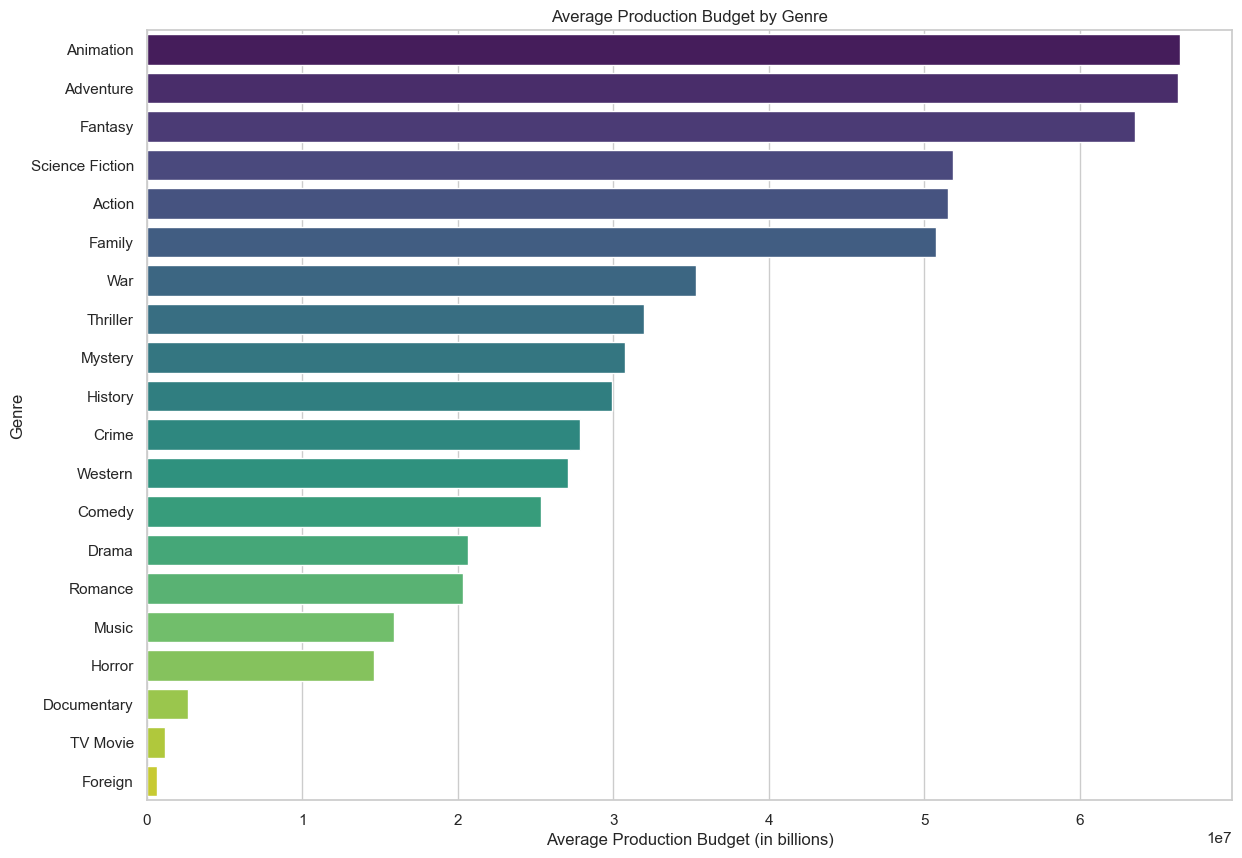

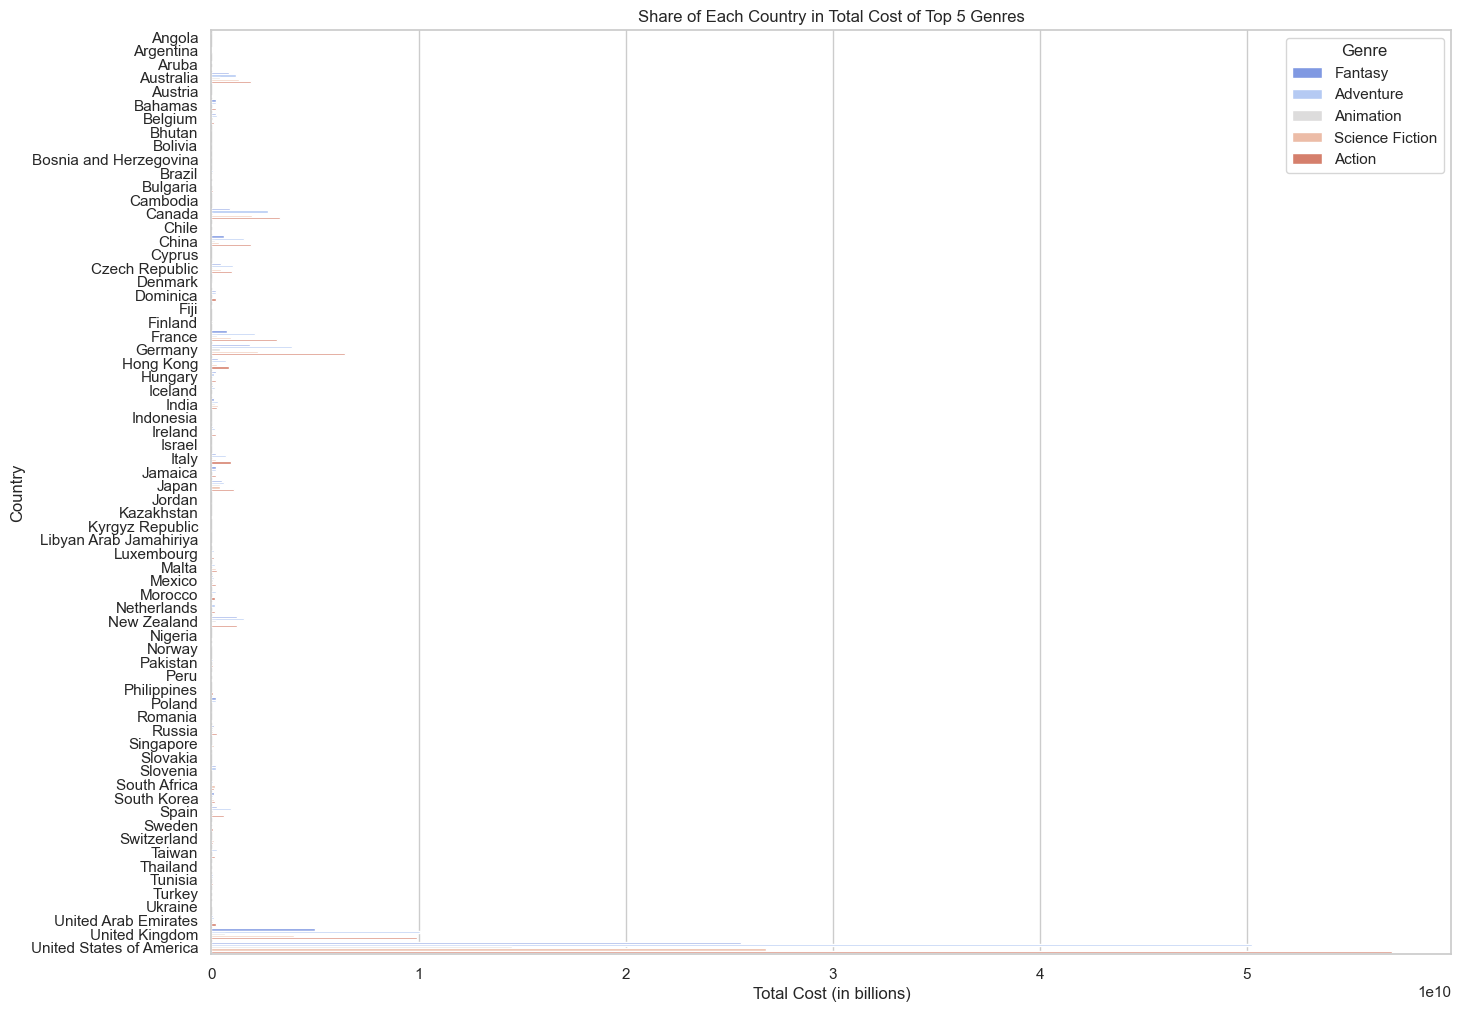

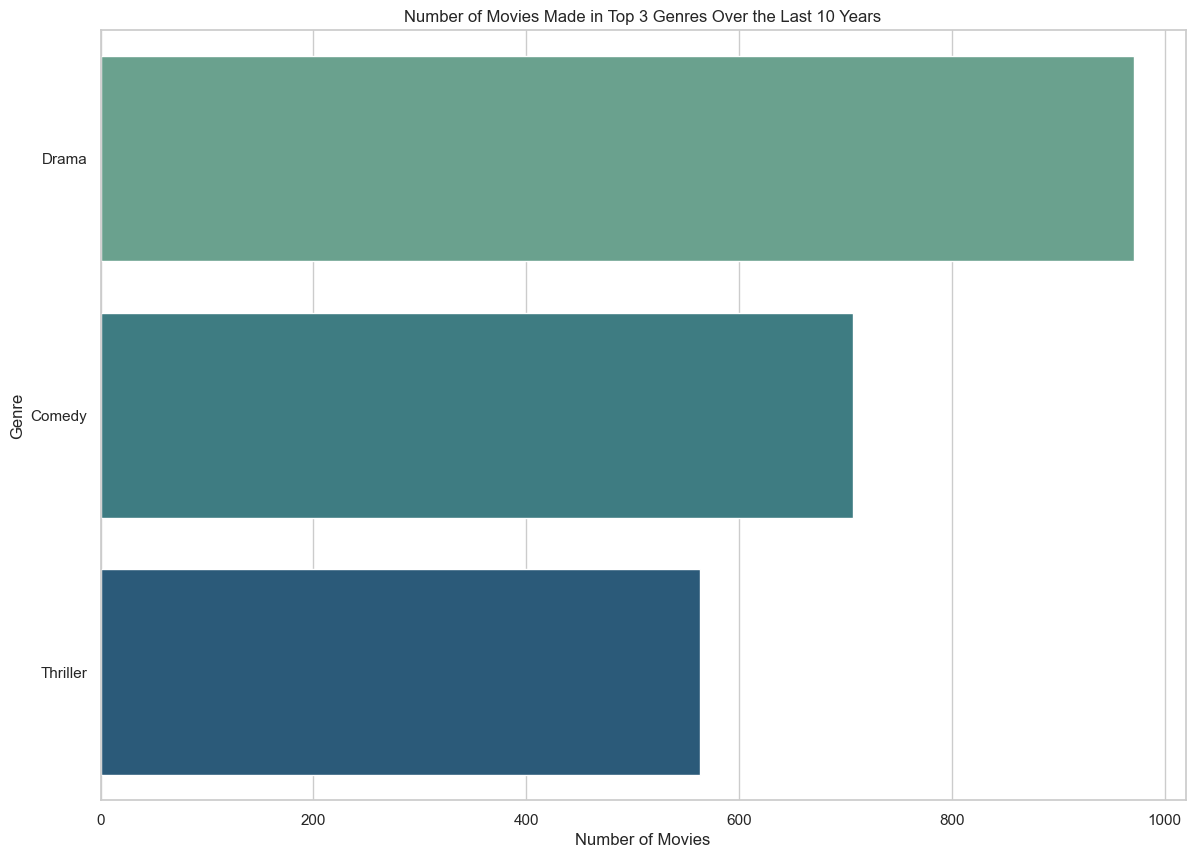

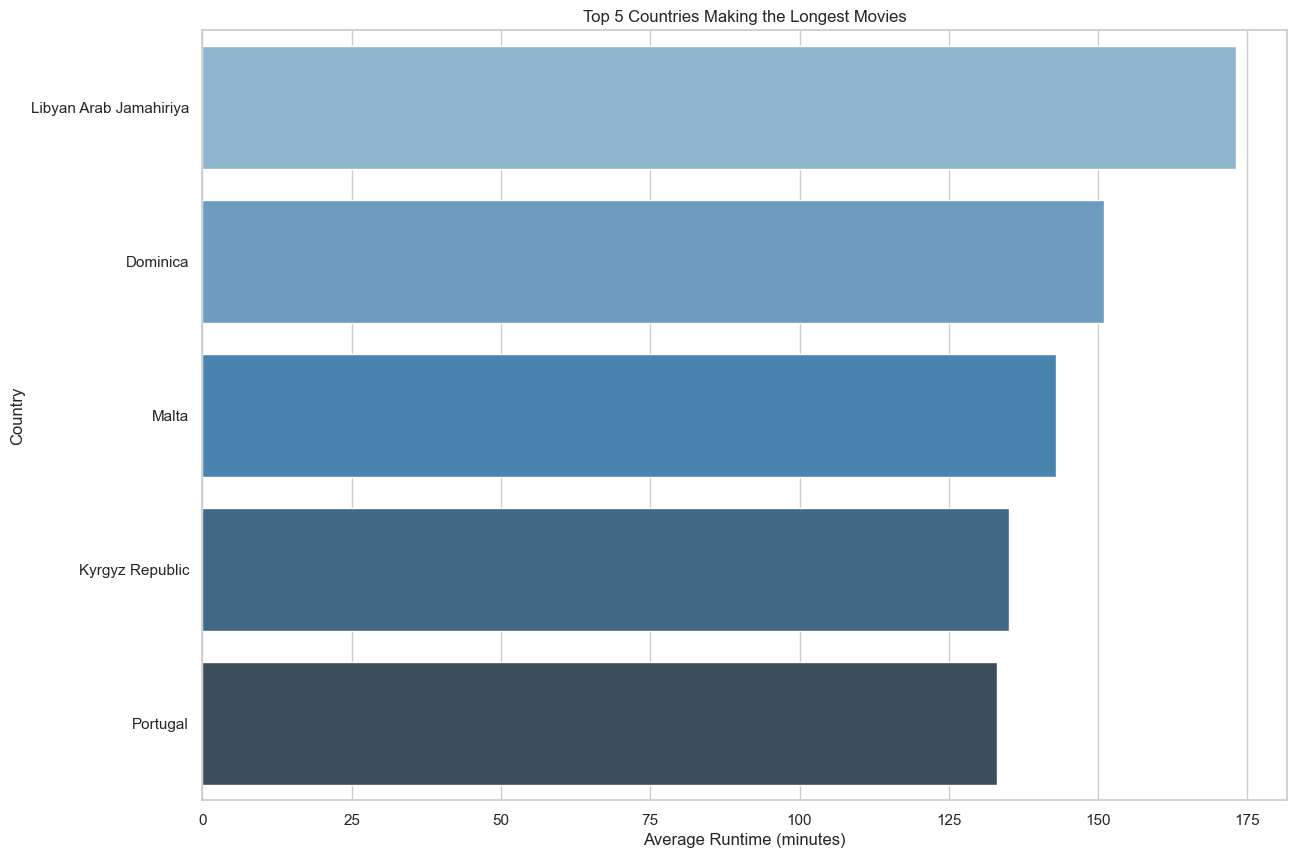

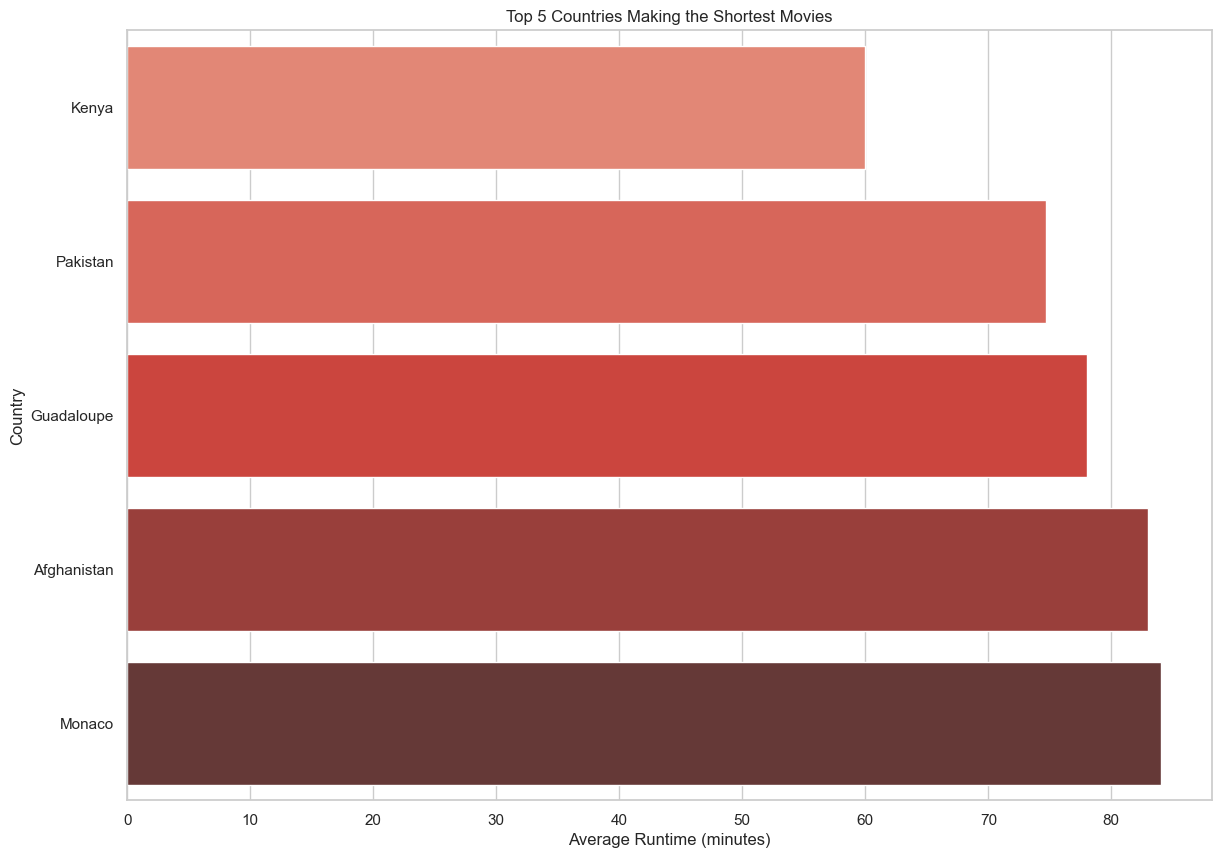

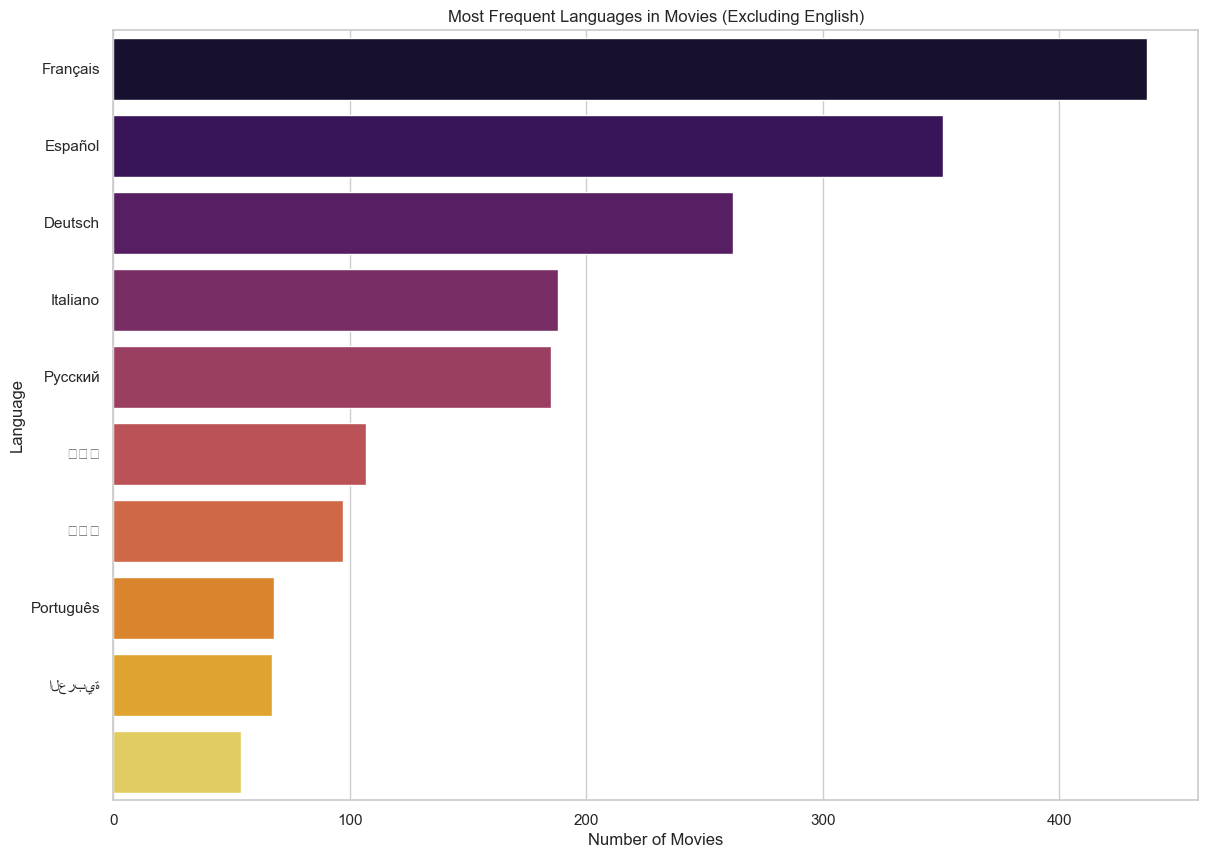

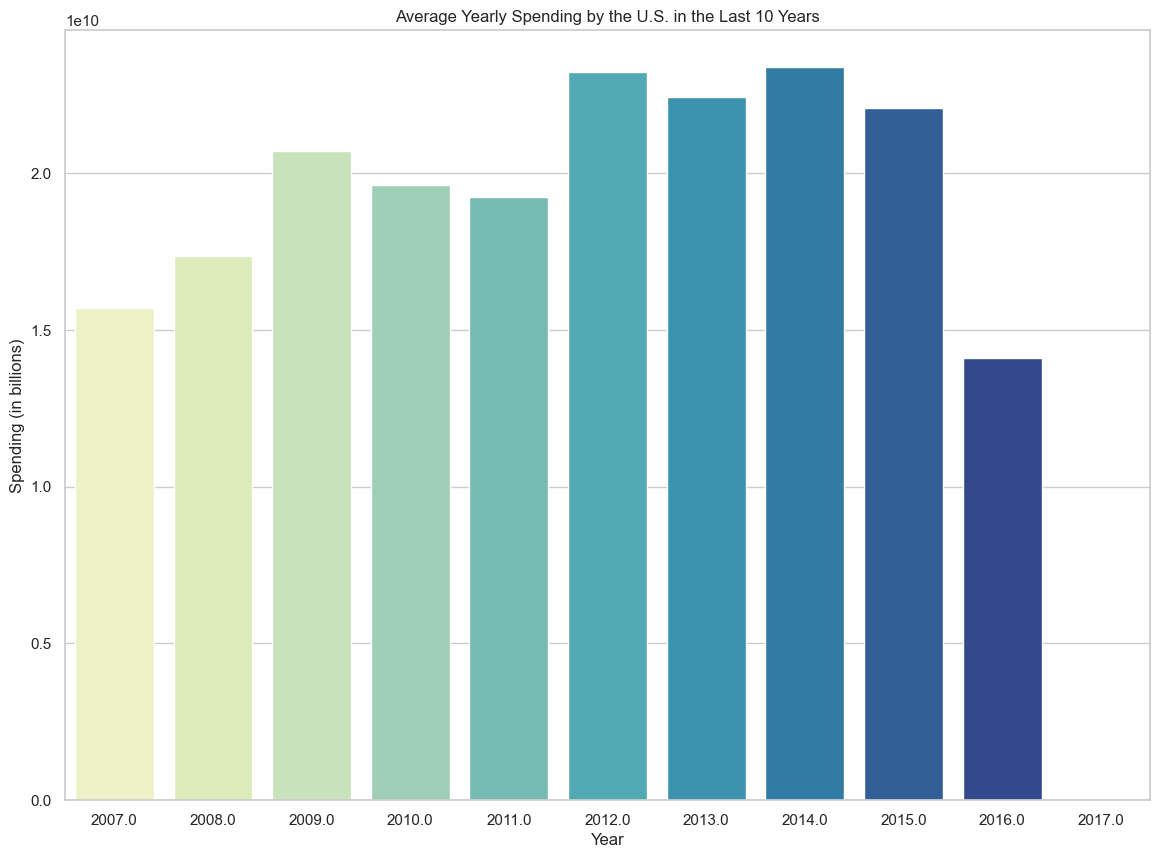

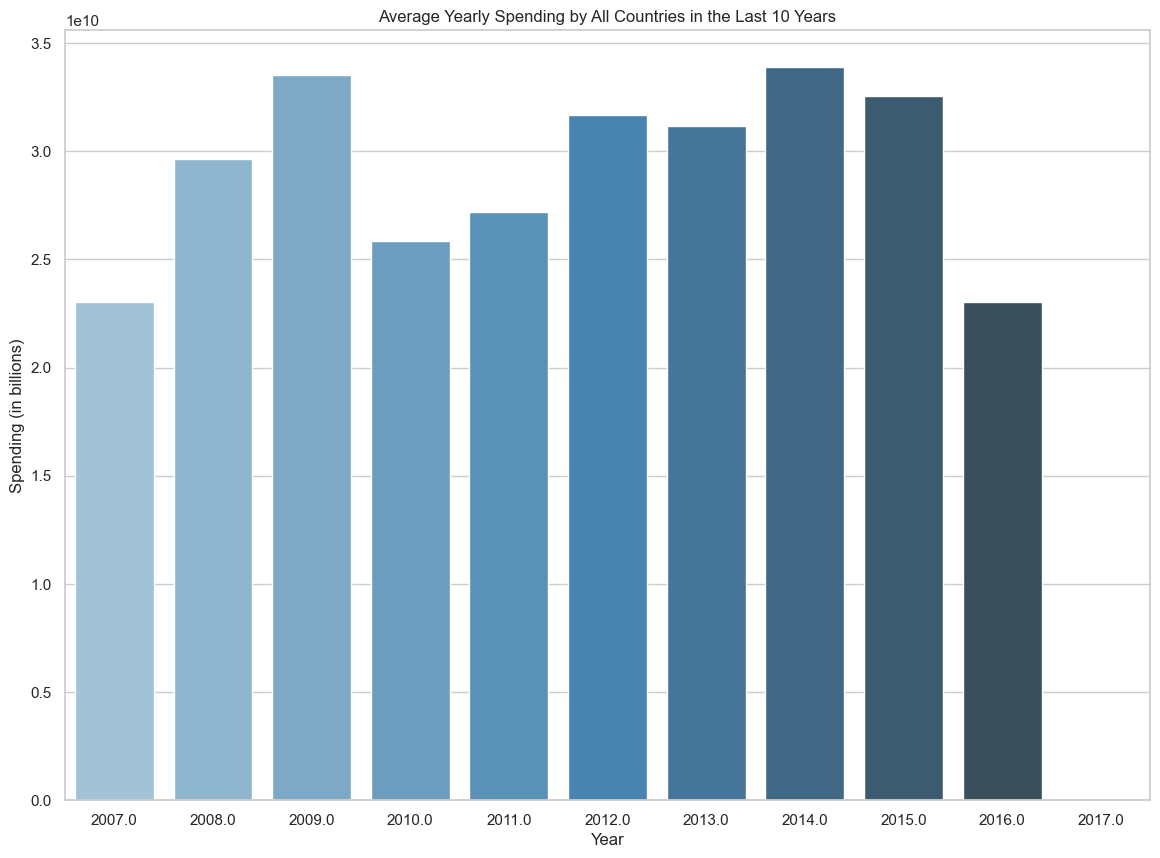

Movies featuring Johnny Depp:
["Pirates of the Caribbean: At World's End", "Pirates of the Caribbean: Dead Man's Chest", 'The Lone Ranger', 'Pirates of the Caribbean: On Stranger Tides', 'Alice in Wonderland', 'Alice Through the Looking Glass', 'Charlie and the Chocolate Factory', 'Dark Shadows', 'Rango', 'Pirates of the Caribbean: The Curse of the Black Pearl', 'Public Enemies', 'The Tourist', 'Transcendence', 'Jack and Jill', 'Mortdecai', 'Black Mass', 'Into the Woods', 'From Hell', '21 Jump Street', 'Secret Window', 'The Ninth Gate', 'A Nightmare on Elm Street', 'Donnie Brasco', "The Astronaut's Wife", 'Blow', 'Corpse Bride', 'The Imaginarium of Doctor Parnassus', 'Once Upon a Time in Mexico', 'Chocolat', 'Finding Neverland', 'Don Juan DeMarco', 'The Libertine', 'Edward Scissorhands', 'Fear and Loathing in Las Vegas', 'Ed Wood', "What's Eating Gilbert Grape", 'Platoon', "Freddy's Dead: The Final Nightmare", 'Yoga Hosers', 'Tusk']


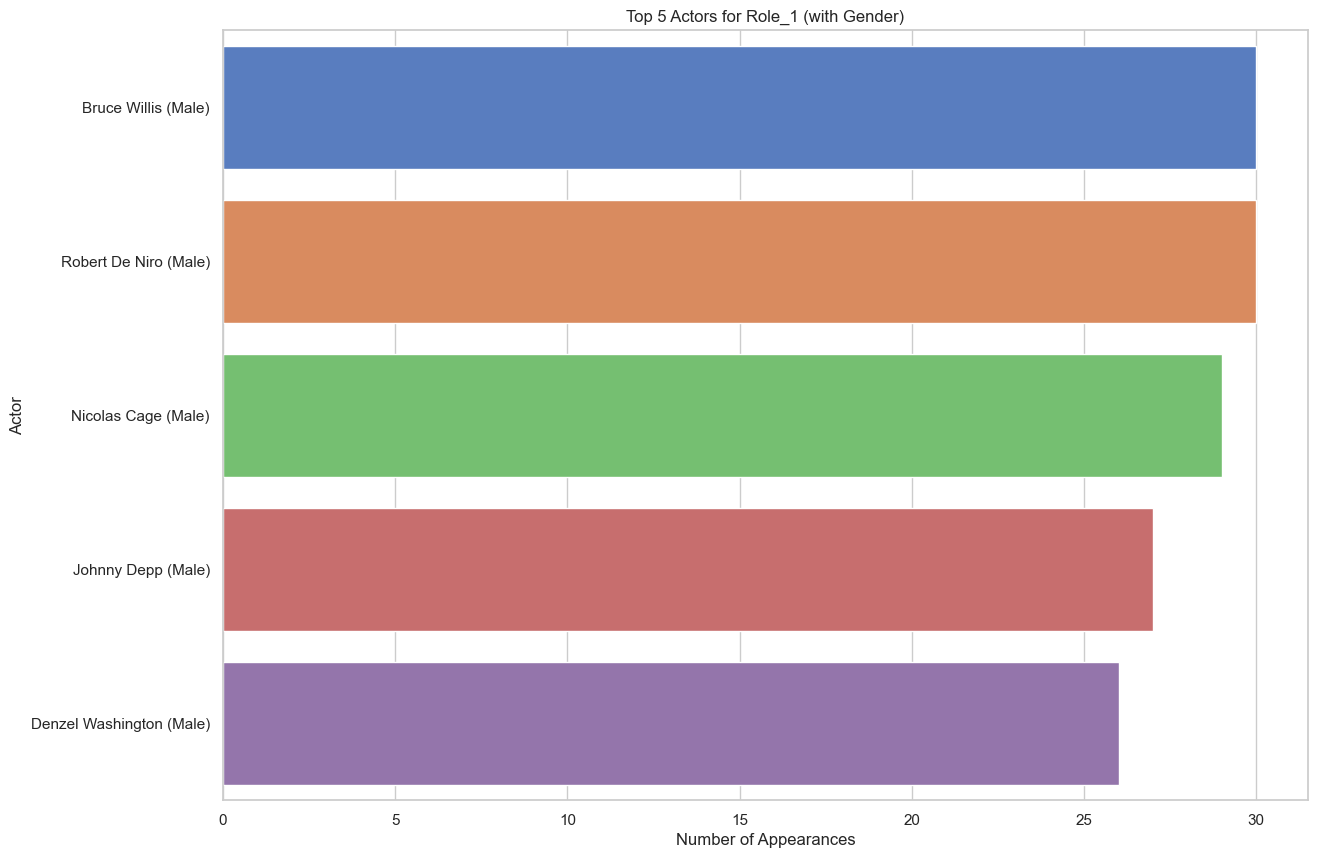

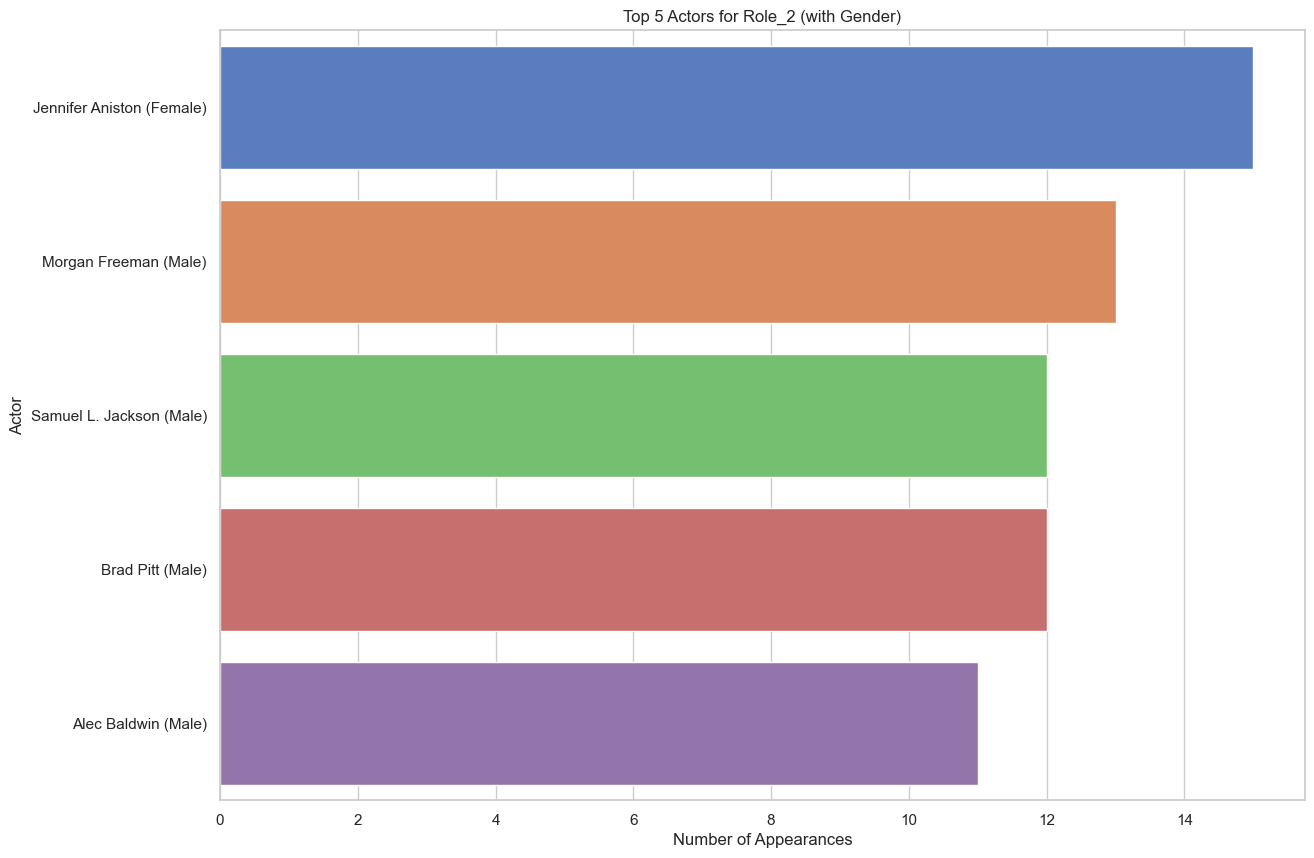

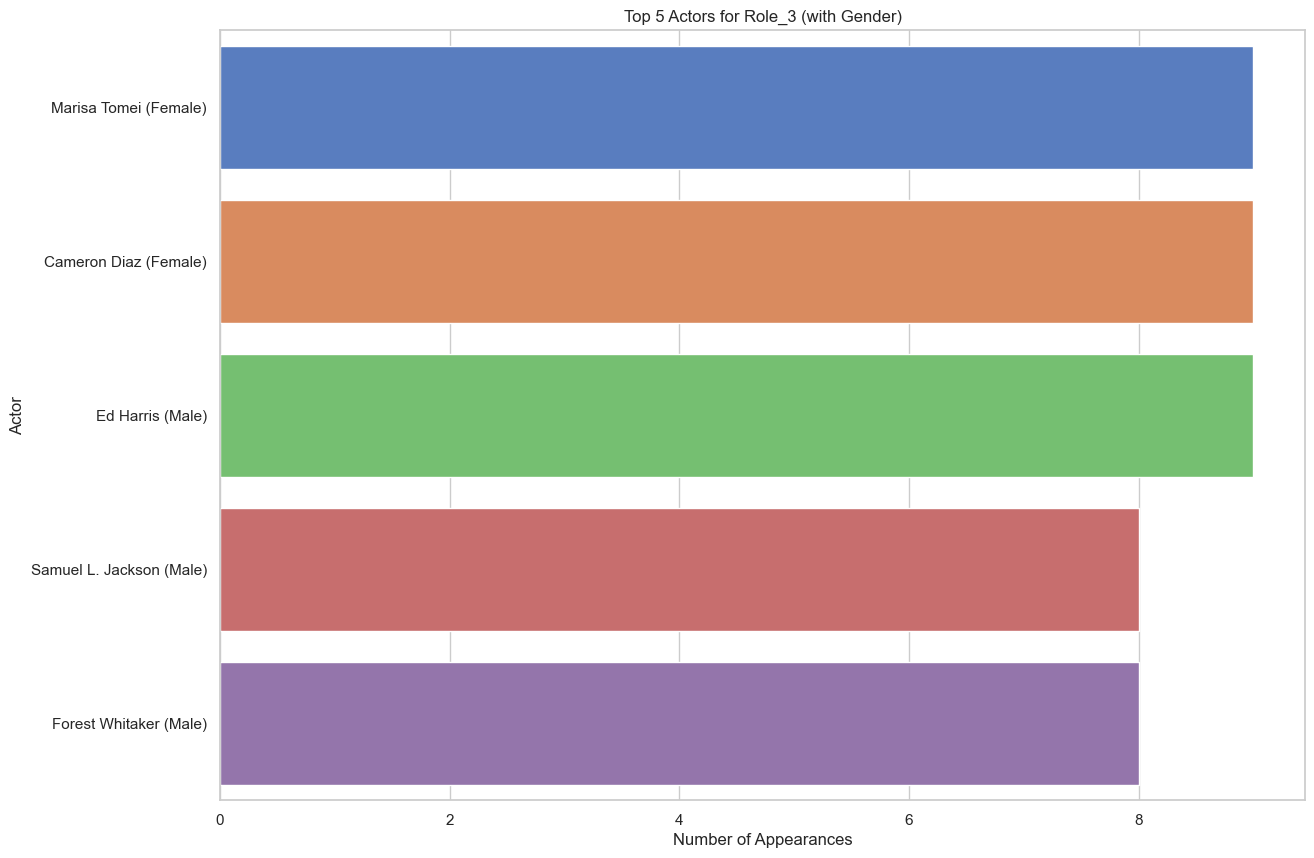

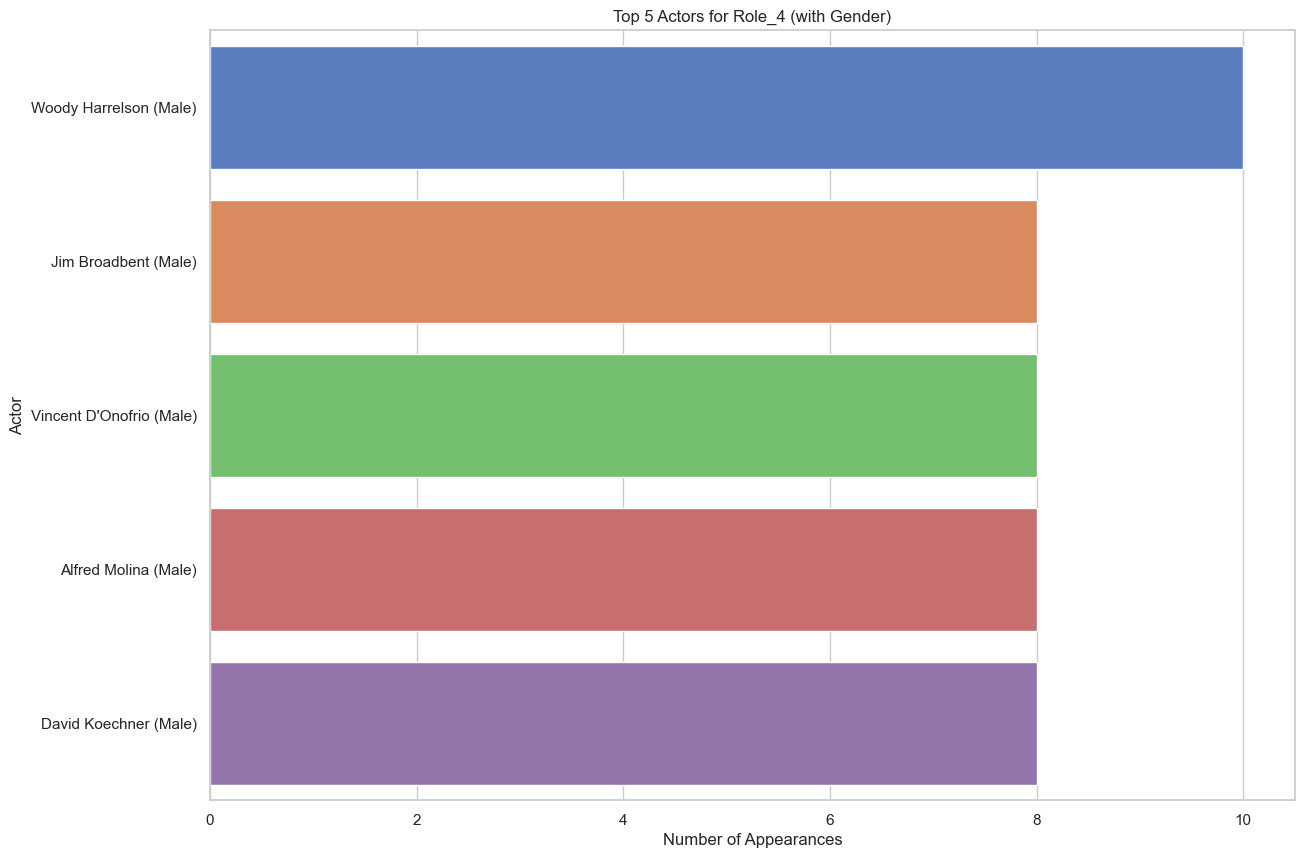

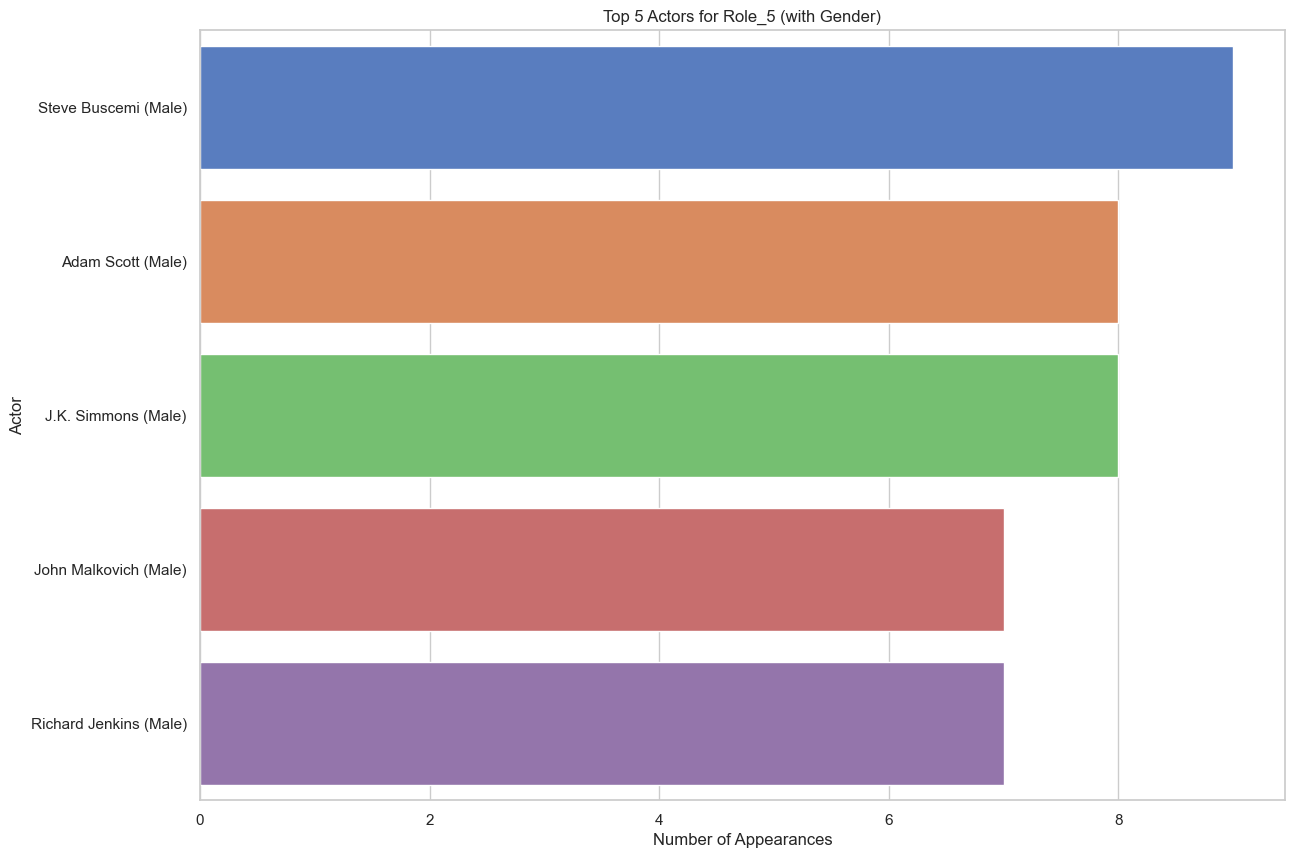

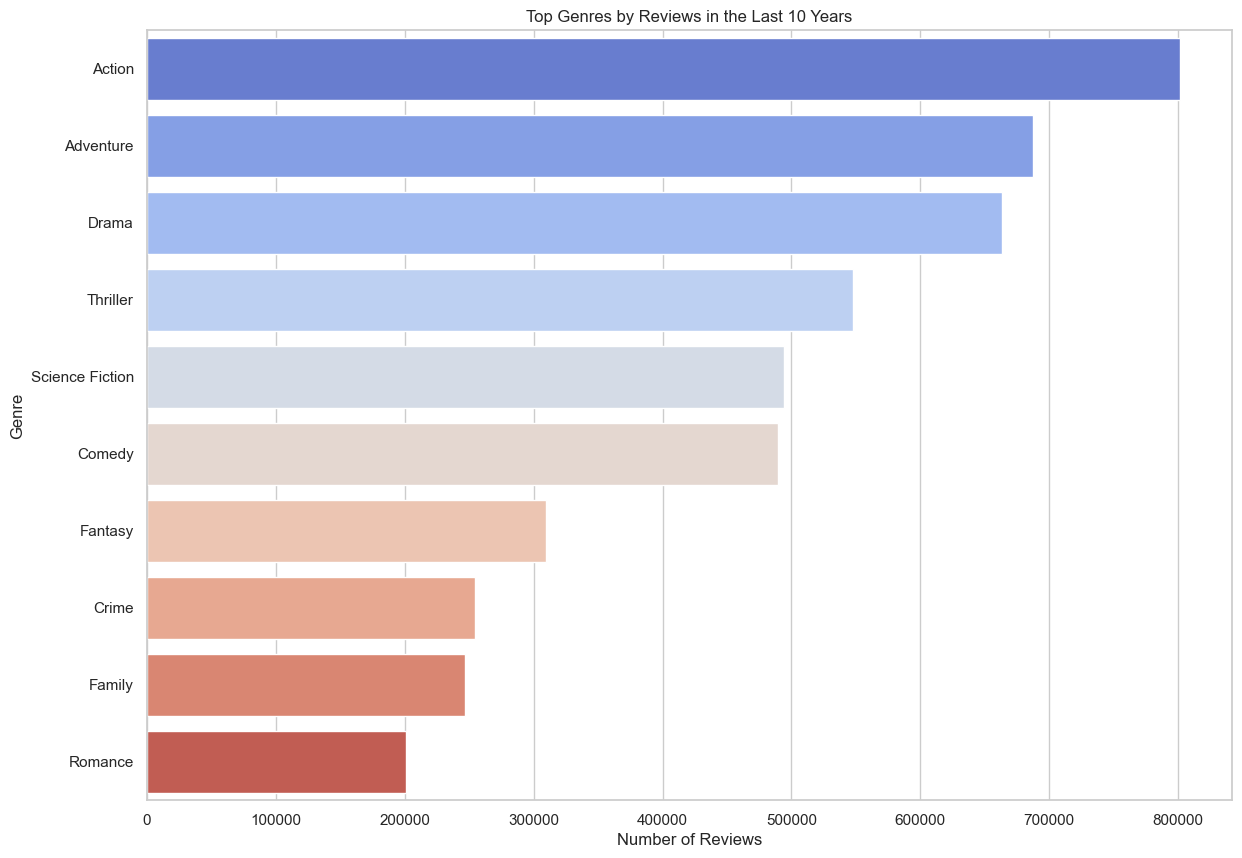

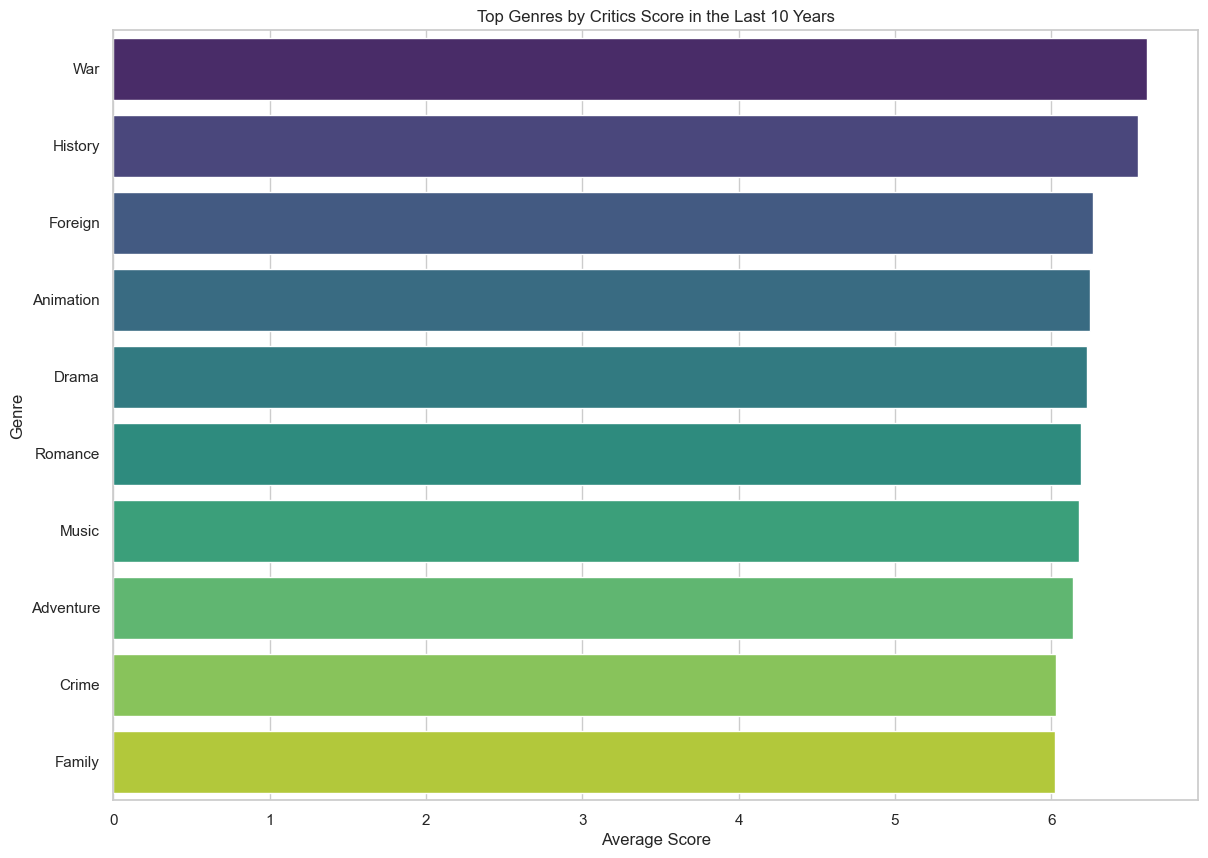

In [9]:
sns.set(style="whitegrid")

# Merging DataFrames
df_credit_cleaned = df_credit_cleaned.merge(
    df_movies[['rt_movie_id', 'rt_release_date', 'rt_runtime']],
    on='rt_movie_id',
    how='left'
)
df_credit_cleaned['release_year'] = pd.to_datetime(df_credit_cleaned['rt_release_date']).dt.year
df_credit_cleaned['rt_runtime'] = pd.to_numeric(df_credit_cleaned['rt_runtime'], errors='coerce')

# ============================
# Question 1: Average Production Cost per Genre
# ============================
# Flattening the genre costs and calculating average budget
flat_genre_budget = pd.DataFrame([
    {'Genre': genre, 'Budget': stats['total_budget']}
    for _, row in df_credit_cleaned.iterrows()
    if isinstance(row['genre_costs'], dict)  # Ensure genre_costs is a dictionary
    for genre, stats in row['genre_costs'].items()
])

genre_budget_avg = flat_genre_budget.groupby('Genre')['Budget'].mean().sort_values(ascending=False)

# Plotting the average production budget by genre
plt.figure(figsize=(14, 10))
sns.barplot(x=genre_budget_avg.values, y=genre_budget_avg.index, palette="viridis")
plt.title('Average Production Budget by Genre')
plt.xlabel('Average Production Budget (in billions)')
plt.ylabel('Genre')
plt.savefig('average_production_budget_by_genre.png')
plt.show()

# ============================
# Question 2: Share of Each Country in Total Cost of the Top 5 Most Expensive Genres
# ============================
# Filtering genres and countries
df_credit_cleaned = df_credit_cleaned[
    df_credit_cleaned['parsed_genres'].apply(lambda x: isinstance(x, list)) &
    df_credit_cleaned['parsed_countries'].apply(lambda x: isinstance(x, list))
]

# Extracting genre costs
flat_genre_budget = pd.DataFrame([
    {'Genre': genre, 'Budget': row['rt_production_budget']}
    for _, row in df_credit_cleaned.iterrows()
    for genre in row['parsed_genres']
])

genre_budget_avg = flat_genre_budget.groupby('Genre')['Budget'].mean().sort_values(ascending=False)
top_5_genres = genre_budget_avg.head(5).index

# Extracting country and genre cost info
flat_country_genre_cost = pd.DataFrame([
    {'Genre': genre, 'Country': country, 'Total Cost': row['rt_production_budget']}
    for _, row in df_credit_cleaned.iterrows()
    for genre in row['parsed_genres']
    for country in row['parsed_countries']
])

flat_country_genre_cost = flat_country_genre_cost[flat_country_genre_cost['Genre'].isin(top_5_genres)]
country_genre_cost_summary = (
    flat_country_genre_cost.groupby(['Country', 'Genre'])['Total Cost']
    .sum()
    .reset_index()
)

# Plotting share of each country in total cost for top genres
plt.figure(figsize=(16, 12))
sns.barplot(
    data=country_genre_cost_summary,
    x='Total Cost',
    y='Country',
    hue='Genre',
    palette="coolwarm"
)
plt.title('Share of Each Country in Total Cost of Top 5 Genres')
plt.xlabel('Total Cost (in billions)')
plt.ylabel('Country')
plt.legend(title="Genre")
plt.savefig('country_share_in_top_genres.png')
plt.show()

# ============================
# Question 3: Number of Movies Made in 3 Genres Over the Past 10 Years
# ============================
last_10_years = df_credit_cleaned[df_credit_cleaned['release_year'] >= (df_credit_cleaned['release_year'].max() - 10)]
flat_recent_genre_count = pd.DataFrame([
    {'Genre': genre, 'Count': 1}
    for _, row in last_10_years.iterrows()
    for genre in row['parsed_genres']
])

# Plotting the number of movies made in the top 3 genres
genre_counts = flat_recent_genre_count.groupby('Genre')['Count'].sum().nlargest(3).reset_index()
plt.figure(figsize=(14, 10))
sns.barplot(data=genre_counts, y='Genre', x='Count', palette="crest")
plt.title('Number of Movies Made in Top 3 Genres Over the Last 10 Years')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.savefig('movies_last_ten_years_by_genre.png')
plt.show()

# ============================
# Question 4: Longest and Shortest Movies by Country
# ============================
flat_country_runtime = df_credit_cleaned.explode('parsed_countries').groupby('parsed_countries')['rt_runtime'].mean().dropna()
longest_countries = flat_country_runtime.nlargest(5)
shortest_countries = flat_country_runtime.nsmallest(5)

# Plotting longest movies
plt.figure(figsize=(14, 10))
sns.barplot(x=longest_countries.values, y=longest_countries.index, palette="Blues_d")
plt.title('Top 5 Countries Making the Longest Movies')
plt.xlabel('Average Runtime (minutes)')
plt.ylabel('Country')
plt.savefig('longest_movies_by_country.png')
plt.show()

# Plotting shortest movies
plt.figure(figsize=(14, 10))
sns.barplot(x=shortest_countries.values, y=shortest_countries.index, palette="Reds_d")
plt.title('Top 5 Countries Making the Shortest Movies')
plt.xlabel('Average Runtime (minutes)')
plt.ylabel('Country')
plt.savefig('shortest_movies_by_country.png')
plt.show()

# ============================
# Question 5: Most Frequent Languages in Movies (Excluding English)
# ============================
flat_language_count = df_credit_cleaned.explode('parsed_languages')
language_counts = flat_language_count['parsed_languages'].value_counts()
language_counts = language_counts[language_counts.index != 'English'].head(10)

# Plotting the most frequent languages
plt.figure(figsize=(14, 10))
sns.barplot(x=language_counts.values, y=language_counts.index, palette="inferno")
plt.title('Most Frequent Languages in Movies (Excluding English)')
plt.xlabel('Number of Movies')
plt.ylabel('Language')
plt.savefig('frequent_languages_excluding_english.png')
plt.show()

# ============================
# Question 6: Average Yearly Spending by the U.S. in the Past 10 Years
# ============================
df_credit_cleaned['us_spending'] = df_credit_cleaned['country_revenue'].apply(
    lambda x: x.get('United States of America', 0) if isinstance(x, dict) else 0
)
last_10_years = df_credit_cleaned[df_credit_cleaned['release_year'] >= (df_credit_cleaned['release_year'].max() - 10)]
us_spending_by_year = last_10_years.groupby('release_year')['us_spending'].sum()

# Plotting U.S. yearly spending
plt.figure(figsize=(14, 10))
sns.barplot(x=us_spending_by_year.index, y=us_spending_by_year.values, palette="YlGnBu")
plt.title('Average Yearly Spending by the U.S. in the Last 10 Years')
plt.xlabel('Year')
plt.ylabel('Spending (in billions)')
plt.savefig('us_yearly_spending.png')
plt.show()

# ============================
# Question 7: Average Yearly Spending by All Countries in the Past 10 Years
# ============================
total_spending_by_year = last_10_years.groupby('release_year')['country_revenue'].apply(
    lambda x: sum([sum(revenues.values()) for revenues in x])
)

# Plotting total yearly spending by all countries
plt.figure(figsize=(14, 10))
sns.barplot(x=total_spending_by_year.index, y=total_spending_by_year.values, palette="Blues_d")
plt.title('Average Yearly Spending by All Countries in the Last 10 Years')
plt.xlabel('Year')
plt.ylabel('Spending (in billions)')
plt.savefig('yearly_spending_all_countries.png')
plt.show()

# ============================
# Question 8: Movies Featuring Johnny Depp
# ============================
johnny_depp_movies = df_credit_cleaned[
    df_credit_cleaned['parsed_actors'].apply(
        lambda actors: any(actor['name'] == 'Johnny Depp' for actor in actors if isinstance(actor, dict))
    )
]['rt_title']

print("Movies featuring Johnny Depp:")
print(johnny_depp_movies.tolist())

# ============================
# Question 9: Top 5 Actors For Each Role
# ============================
for i in range(1, 6):
    df_credit_cleaned[f'role_{i}'] = df_credit_cleaned['parsed_actors'].apply(
        lambda actors: {'name': actors[i - 1]['name'], 'gender': actors[i - 1]['gender']}
        if len(actors) >= i and isinstance(actors[i - 1], dict) else None
    )
role_counts_with_gender = {}
for i in range(1, 6):
    role_col = f'role_{i}'
    role_counts_with_gender[role_col] = (
        df_credit_cleaned[role_col]
        .dropna()
        .apply(lambda x: (x['name'], x['gender']))
        .value_counts()
        .head(5)
    )
for role, counts in role_counts_with_gender.items():
    actors = [f"{actor[0]} (Male)" if actor[1] == 2 else f"{actor[0]} (Female)" for actor in counts.index]
    counts_values = counts.values
    plt.figure(figsize=(14, 10))
    sns.barplot(x=counts_values, y=actors, palette="muted")
    plt.title(f'Top 5 Actors for {role.capitalize()} (with Gender)')
    plt.xlabel('Number of Appearances')
    plt.ylabel('Actor')
    plt.savefig(f'top_5_actors_with_gender_{role}.png')
    plt.show()

# ============================
# Question 10: Most Popular Genres in the Last 10 Years (Reviews and Critics Score)
# ============================
flat_genre_reviews = pd.DataFrame([
    {'Genre': genre, 'Reviews': row['genre_costs'][genre]['total_reviews']}
    for _, row in last_10_years.iterrows()
    for genre in row['genre_costs']
])

flat_genre_scores = pd.DataFrame([
    {'Genre': genre, 'Score': row['genre_costs'][genre]['critics_score']}
    for _, row in last_10_years.iterrows()
    for genre in row['genre_costs']
])

genre_reviews_top = flat_genre_reviews.groupby('Genre')['Reviews'].sum().sort_values(ascending=False).head(10)
genre_scores_top = flat_genre_scores.groupby('Genre')['Score'].mean().sort_values(ascending=False).head(10)

# Plotting top genres by reviews
plt.figure(figsize=(14, 10))
sns.barplot(x=genre_reviews_top.values, y=genre_reviews_top.index, palette="coolwarm")
plt.title('Top Genres by Reviews in the Last 10 Years')
plt.xlabel('Number of Reviews')
plt.ylabel('Genre')
plt.savefig('top_genres_by_reviews.png')
plt.show()

# Plotting top genres by critics score
plt.figure(figsize=(14, 10))
sns.barplot(x=genre_scores_top.values, y=genre_scores_top.index, palette="viridis")
plt.title('Top Genres by Critics Score in the Last 10 Years')
plt.xlabel('Average Score')
plt.ylabel('Genre')
plt.savefig('top_genres_by_score.png')
plt.show()

Movies Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   rt_production_budget     4803 non-null   int64  
 1   rt_genres                4803 non-null   object 
 2   rt_website               1712 non-null   object 
 3   rt_movie_id              4803 non-null   int64  
 4   rt_keywords              4803 non-null   object 
 5   rt_original_language     4803 non-null   object 
 6   rt_original_title        4803 non-null   object 
 7   rt_synopsis              4800 non-null   object 
 8   rt_audience_score        4803 non-null   float64
 9   rt_studios               4803 non-null   object 
 10  rt_production_countries  4803 non-null   object 
 11  rt_release_date          4802 non-null   object 
 12  rt_box_office            4803 non-null   int64  
 13  rt_runtime               4801 non-null   float64
 14  rt_

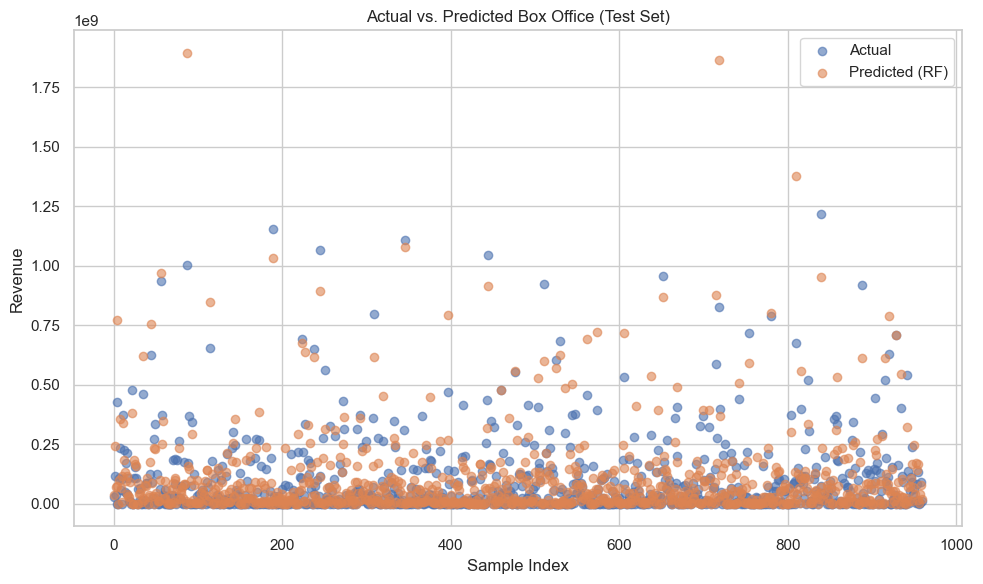

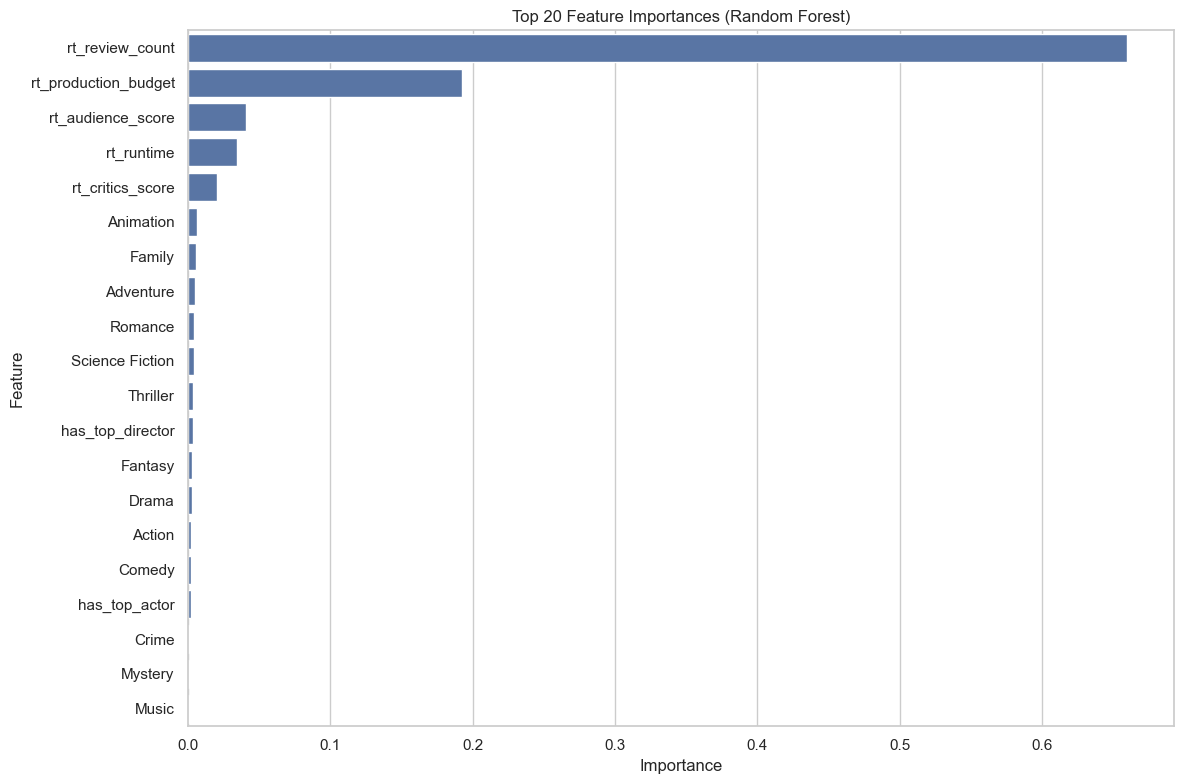


      FINAL REPORT
Model Comparison (Test Set):
Linear Regression -> MSE: 154255434550045452737025602230419456.00, R^2: -5924698524620079104.0000
Decision Tree     -> MSE: 15436837757663670.00, R^2: 0.4071
Random Forest     -> MSE: 6795423371473948.00, R^2: 0.7390
Best RF (Tuned)   -> MSE: 6945492623509476.00, R^2: 0.7332

Feature Importances (Top 20):
                 Feature  Importance
17       rt_review_count    0.659791
20  rt_production_budget    0.192479
12     rt_audience_score    0.041080
25            rt_runtime    0.034577
10      rt_critics_score    0.020209
8              Animation    0.006422
22                Family    0.006019
9              Adventure    0.005276
13               Romance    0.004618
16       Science Fiction    0.004049
21              Thriller    0.003686
23      has_top_director    0.003431
2                Fantasy    0.002988
5                  Drama    0.002807
18                Action    0.002261
1                 Comedy    0.002247
19         has_

In [10]:
# ============================================
# 1. LOADING THE DATASETS
# ============================================
# Adjust the file paths/names as necessary
df_movies = pd.read_csv(r"data/rotten_tomatoes_5000_movies.csv")
df_credit = pd.read_csv(r"data/rotten_tomatoes_5000_credits.csv")

# Optional: View basic information
print("Movies Dataset Info:")
print(df_movies.info())
print("\nCredits Dataset Info:")
print(df_credit.info())

# Optional: Quick preview
print("\nMovies Dataset Preview:")
print(df_movies.head())
print("\nCredits Dataset Preview:")
print(df_credit.head())

# ============================================
# 2. INITIAL DATA EXPLORATION & MISSING VALUES
# ============================================
print("\nMissing Values in Movies Dataset:")
print(df_movies.isnull().sum())

print("\nMissing Values in Credits Dataset:")
print(df_credit.isnull().sum())

# ============================================
# 3. MERGING THE DATASETS
# ============================================
# Assuming 'rt_movie_id' and 'rt_title' are the common keys between the two DataFrames
merged_df = pd.merge(df_movies, df_credit, on=['rt_movie_id', 'rt_title'], how='left')

# Check merged dataset shape and info
print("\nMerged Dataset Shape:", merged_df.shape)
print(merged_df.info())

# ============================================
# 4. DATA CLEANING & MISSING VALUE HANDLING
# ============================================

# --- 4.1 Drop columns with too many missing values or not relevant ---
# 'rt_website' has 3091 missing values; 'rt_tagline' has 844 missing values
merged_df.drop(columns=['rt_website', 'rt_tagline'], inplace=True)

# --- 4.2 Handle remaining missing values ---
# Drop rows with missing 'rt_release_date' or 'rt_synopsis'
merged_df.dropna(subset=['rt_release_date', 'rt_synopsis'], inplace=True)

# Fill missing 'rt_runtime' with the mean runtime
merged_df['rt_runtime'].fillna(merged_df['rt_runtime'].mean(), inplace=True)

# Confirm missing values again
print("\nMissing Values After Initial Cleaning:")
print(merged_df.isnull().sum())

# ============================================
# 5. FEATURE ENGINEERING
# ============================================

# Our target variable is 'rt_box_office', i.e., movie revenue.

# --- 5.1 Parsing Genres to create dummy variables ---
def parse_genres(genre_str):
    """
    Parses the 'rt_genres' JSON-like string and returns a list of genre names.
    """
    try:
        genres = ast.literal_eval(genre_str)
        return [g['name'] for g in genres]
    except:
        return []

merged_df['parsed_genres'] = merged_df['rt_genres'].apply(parse_genres)

# Get a sorted list of all unique genres
all_genres = sorted(list(set(genre for genres in merged_df['parsed_genres'] for genre in genres)))

# Initialize genre columns with 0
for genre in all_genres:
    merged_df[genre] = 0

# Mark 1 where the movie has the genre
for i, genres in enumerate(merged_df['parsed_genres']):
    for genre in genres:
        merged_df.at[i, genre] = 1

# Drop the original 'rt_genres' and 'parsed_genres' columns
merged_df.drop(columns=['rt_genres', 'parsed_genres'], inplace=True)

# --- 5.2 Actors/Directors Influence ---

# Extract actor names from 'rt_actors'
def extract_actor_names(cast_str):
    try:
        cast_list = ast.literal_eval(cast_str)
        return [cast_member['name'] for cast_member in cast_list]
    except:
        return []

merged_df['actor_names'] = merged_df['rt_actors'].apply(extract_actor_names)

# Count the frequency of each actor
actor_counter = Counter(actor for actors in merged_df['actor_names'] for actor in actors)

# Select top 50 actors as "famous"
top_actors = set([actor for actor, count in actor_counter.most_common(50)])

# Create a feature "has_top_actor" that is 1 if any top actor is in the cast, else 0
merged_df['has_top_actor'] = merged_df['actor_names'].apply(lambda actors: 1 if any(actor in top_actors for actor in actors) else 0)

# Extract director names from 'rt_staff'
def extract_director(staff_str):
    try:
        staff_list = ast.literal_eval(staff_str)
        for staff_member in staff_list:
            if staff_member.get('department', '').lower() == 'directing' and staff_member.get('job', '').lower() == 'director':
                return staff_member['name']
        return None
    except:
        return None

merged_df['director_name'] = merged_df['rt_staff'].apply(extract_director)

# Count the frequency of each director
director_counter = merged_df['director_name'].value_counts()

# Select top 20 directors as "famous"
top_directors = set(director_counter.head(20).index)

# Create a feature "has_top_director" that is 1 if the director is in top directors, else 0
merged_df['has_top_director'] = merged_df['director_name'].apply(lambda director: 1 if director in top_directors else 0)

# Drop raw columns after extracting features
merged_df.drop(columns=['rt_actors', 'rt_staff', 'actor_names', 'director_name'], inplace=True)

# ============================================
# 6. SELECTING FEATURES & TARGET
# ============================================

# --- 6.1 Ensure No Missing Values in Target Variable ---
# Check for missing values in 'rt_box_office'
missing_y = merged_df['rt_box_office'].isnull().sum()
print(f"\nNumber of missing values in target (y): {missing_y}")

# If there are missing values, drop those rows
if missing_y > 0:
    print(f"Dropping {missing_y} rows with missing target values.")
    merged_df = merged_df.dropna(subset=['rt_box_office'])

# --- 6.2 Define Target and Features ---
y = merged_df['rt_box_office'].values

# Define feature columns
feature_cols = [
    'rt_production_budget', 
    'rt_original_language',
    'rt_runtime',
    'rt_critics_score',
    'rt_audience_score',
    'rt_review_count',
    'has_top_actor',
    'has_top_director'
] + all_genres

X = merged_df[feature_cols].copy()

# Verify that there are no missing values in y
print("\nNumber of missing values in target (y) after cleaning:", np.isnan(y).sum())
assert not np.isnan(y).any(), "Target variable y contains missing values."

# ============================================
# 7. TRAIN-TEST SPLIT
# ============================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

print(f"\nTraining Set: {X_train.shape}, Test Set: {X_test.shape}")

# ============================================
# 8. PIPELINE & PREPROCESSING
# ============================================

# Identify categorical vs. numeric columns
categorical_features = ['rt_original_language']
numeric_features = list(set(feature_cols) - set(categorical_features))

# Define transformers for numeric and categorical features
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing numeric values with mean
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing categorical values with mode
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers into a ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# ============================================
# 9. MODEL TRAINING & COMPARISON
# ============================================

# --- 9.1 Linear Regression ---
lr_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Confirm no missing values in y_train
print("\nNumber of missing values in y_train:", np.isnan(y_train).sum())
assert not np.isnan(y_train).any(), "y_train contains missing values."

# Train Linear Regression model
lr_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_lr = lr_model.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("\nLinear Regression Results:")
print(f"MSE: {mse_lr:.2f}")
print(f"R^2: {r2_lr:.4f}")

# --- 9.2 Decision Tree Regressor ---
dt_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

# Train Decision Tree model
dt_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_dt = dt_model.predict(X_test)
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print("\nDecision Tree Regressor Results:")
print(f"MSE: {mse_dt:.2f}")
print(f"R^2: {r2_dt:.4f}")

# --- 9.3 Random Forest Regressor ---
rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Train Random Forest model
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\nRandom Forest Regressor Results:")
print(f"MSE: {mse_rf:.2f}")
print(f"R^2: {r2_rf:.4f}")

# Uncomment the following block to include XGBoost

# --- 9.4 XGBoost Regressor ---
xgb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_estimators=100,
        learning_rate=0.1
    ))
])

# Train XGBoost model
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = xgb_model.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\nXGBoost Regressor Results:")
print(f"MSE: {mse_xgb:.2f}")
print(f"R^2: {r2_xgb:.4f}")

# ============================================
# 10. HYPERPARAMETER TUNING (Example with Random Forest)
# ============================================

param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5],
}

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

grid_search = GridSearchCV(
    rf_pipeline, 
    param_grid, 
    scoring='neg_mean_squared_error', 
    cv=3, 
    n_jobs=-1, 
    verbose=2
)

# Confirm no missing values in y_train before GridSearchCV
print("\nNumber of missing values in y_train before GridSearchCV:", np.isnan(y_train).sum())
assert not np.isnan(y_train).any(), "y_train contains missing values before GridSearchCV."

# Perform Grid Search
grid_search.fit(X_train, y_train)

print("\nBest Parameters for Random Forest:", grid_search.best_params_)
best_rf_model = grid_search.best_estimator_

# Predict and evaluate with the best Random Forest model
y_pred_best_rf = best_rf_model.predict(X_test)
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)

print("\nBest Random Forest Model Results:")
print(f"MSE: {mse_best_rf:.2f}")
print(f"R^2: {r2_best_rf:.4f}")

# ============================================
# 11. EVALUATION & VISUALIZATION
# ============================================

# --- 11.1 Check for any remaining missing values in y_test ---
print("\nNumber of missing values in y_test:", np.isnan(y_test).sum())
assert not np.isnan(y_test).any(), "y_test contains missing values."

# --- 11.2 Actual vs. Predicted Plot ---
plt.figure(figsize=(10,6))
plt.scatter(range(len(y_test)), y_test, label='Actual', alpha=0.6)
plt.scatter(range(len(y_test)), y_pred_best_rf, label='Predicted (RF)', alpha=0.6)
plt.title('Actual vs. Predicted Box Office (Test Set)')
plt.xlabel('Sample Index')
plt.ylabel('Revenue')
plt.legend()
plt.tight_layout()
plt.show()

# --- 11.3 Feature Importance ---
# Extract feature importances from the Random Forest model
final_rf = best_rf_model.named_steps['regressor']
preprocessor_step = best_rf_model.named_steps['preprocessor']

# Retrieve feature names after preprocessing
# Get numeric feature names
numeric_features_after = numeric_features  # Already sorted

# Get categorical feature names after one-hot encoding
onehot = preprocessor_step.named_transformers_['cat'].named_steps['onehot']
cat_col_names = onehot.get_feature_names_out(categorical_features)

# Combine all feature names
all_transformed_cols = list(numeric_features_after) + list(cat_col_names)

# Ensure the length matches
if len(all_transformed_cols) != len(final_rf.feature_importances_):
    print("\nWarning: Mismatch in feature names and importances. Check preprocessing steps.")
else:
    importances = final_rf.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': all_transformed_cols,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    # Plotting feature importance
    plt.figure(figsize=(12,8))
    sns.barplot(data=feature_importance_df.head(20), x='Importance', y='Feature')
    plt.title('Top 20 Feature Importances (Random Forest)')
    plt.tight_layout()
    plt.show()

# ============================================
# 12. CONCLUSION / REPORTING
# ============================================

# Print out a quick summary
print("\n============================")
print("      FINAL REPORT")
print("============================")
print("Model Comparison (Test Set):")
print(f"Linear Regression -> MSE: {mse_lr:.2f}, R^2: {r2_lr:.4f}")
print(f"Decision Tree     -> MSE: {mse_dt:.2f}, R^2: {r2_dt:.4f}")
print(f"Random Forest     -> MSE: {mse_rf:.2f}, R^2: {r2_rf:.4f}")
print(f"Best RF (Tuned)   -> MSE: {mse_best_rf:.2f}, R^2: {r2_best_rf:.4f}")

if 'feature_importance_df' in locals():
    print("\nFeature Importances (Top 20):")
    print(feature_importance_df.head(20))
else:
    print("\nFeature importances not available due to mismatch in feature names and importances.")

# Additional Analysis Suggestions:
# - Analyze the impact of top actors/directors on revenue.
# - Explore how different genre combinations affect revenue.
# - Investigate temporal trends (e.g., release year/month).

# Optional: Save the best model for future use
# import joblib
# joblib.dump(best_rf_model, 'best_random_forest_model.pkl')